# 527_ra206.248_dec-63.613_MAXIJ1348TraPDB_andersson

In [34]:
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import arviz as az
import graphviz as gv
import utility_functions as ufn
import importlib
import seaborn as sns

importlib.reload(ufn)
az.style.use("arviz-white")

RANDOM_SEED = 2023-11-21
rng = np.random.default_rng(RANDOM_SEED)

OVERWRITE_TRACES = False

Running on PyMC v5.6.1


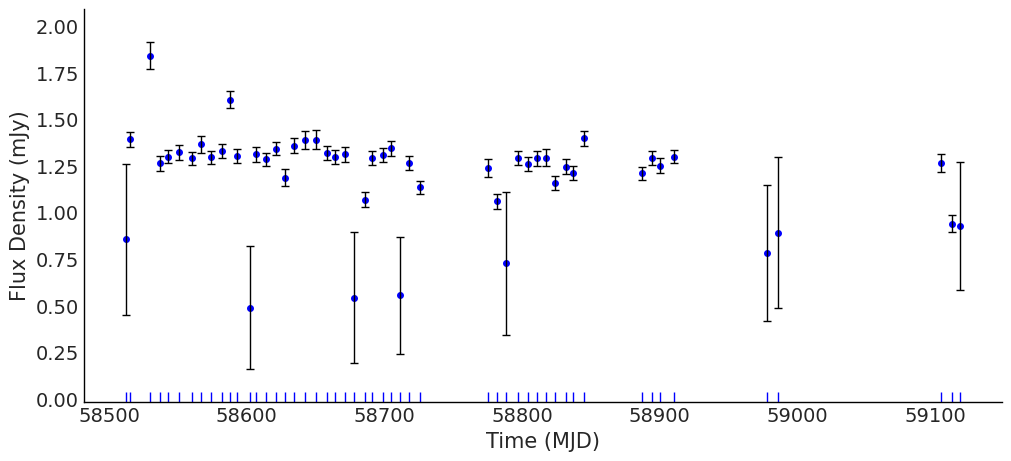

In [4]:
# File paths to CSVs of flux density observations.
csv_paths_list = sorted(list(Path('data_raw').iterdir()))
csv_path = csv_paths_list[3]
ufn.plot_lc(csv_path, save_plot=True)
plt.savefig(f"figures/{csv_path.stem}_lc.jpg", dpi=300, bbox_inches='tight')

## SE GP + Periodic GP

$$ Y = f(t) + \varepsilon$$

$$\varepsilon \sim \mathcal{N}(0, \Sigma_\varepsilon)$$

$$\Sigma_\varepsilon = \boldsymbol{e}^2 \boldsymbol{I}$$

$$f(t) \sim \mathcal{GP}(\boldsymbol{0}, k_\textrm{SE}(\tau)) + \mathcal{GP}(\boldsymbol{0}, k_\textrm{P}(\tau))$$

$$k_\textrm{SE}(\tau) = \eta_\textrm{SE}\exp\left\{ - \frac{1}{2\ell_\textrm{SE}^2}\tau^2\right\}$$

$$\quad k_\textrm{P}(\tau) = \eta_\textrm{P} \exp \left\{ -\frac{1}{2\ell^2_\textrm{P}}\sin^2 \left(\pi\frac{\tau}{T}\right)\right\}$$

$$\ell_\textrm{SE} \sim \textrm{min. gap}(t) + \textrm{InvGamma}\left(\alpha = 3, \beta = \frac{1}{2} \times \textrm{range}(t)\right)$$

$$\ell_\textrm{P} \sim \textrm{min. gap}(t) + \textrm{InvGamma}\left(\alpha = 3, \beta= \frac{1}{2} \times \textrm{range}(t)\right)$$

$$\eta_\textrm{SE} \sim \mathcal{N}^+(0, 1)$$

$$\eta_\textrm{P} \sim \mathcal{N}^+(0, 1)$$

$$T \sim \mathcal{U}\left[4 \times \textrm{min. gap}(t), \frac{1}{4} \times \textrm{range}(t)\right]$$

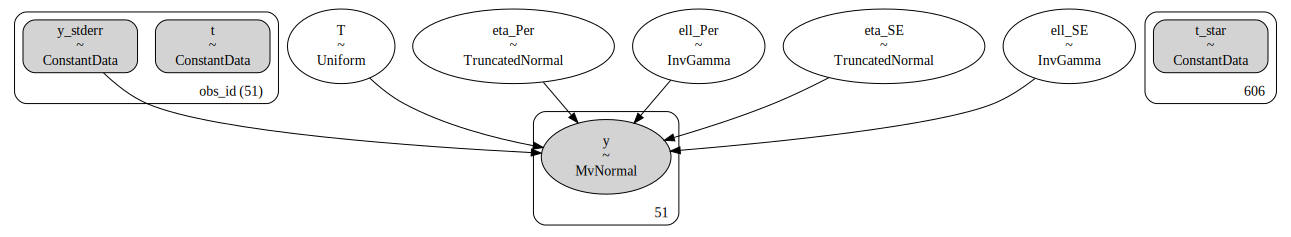

In [5]:
gpSE_gpPer_trace_path = Path(f"traces/{csv_path.stem}_gpSE_gpPer_idata.nc")
gpSE_gpPer_dag_path = Path(f'dags/{csv_path.stem}_gpSE_gpPer_dag.dot')

if gpSE_gpPer_trace_path.is_file() and not OVERWRITE_TRACES:
    gpSE_gpPer_trace = az.from_netcdf(gpSE_gpPer_trace_path)
    gpSE_gpPer_dag = gv.Source.from_file(gpSE_gpPer_dag_path)
else:
    gpSE_gpPer_trace, gpSE_gpPer_dag = ufn.fit_gpSE_gpPer(csv_path, standardise_y=True, rng_seed=rng);
    az.to_netcdf(gpSE_gpPer_trace, gpSE_gpPer_trace_path)
    with open(gpSE_gpPer_dag_path, 'w') as writehandle:
        writehandle.write(gpSE_gpPer_dag.source)

gv.Source(gpSE_gpPer_dag.source)

In [6]:
variable_names = ["ell_SE", "ell_Per", "eta_SE", "eta_Per", "T"]
ufn.print_post_summary(gpSE_gpPer_trace, variable_names)

,median,mad,eti_16%,eti_84%,mcse_median,ess_median,ess_tail,r_hat,mean,sd
ell_SE,16.023679,2.337794,12.456081,19.312824,0.087843,3099.740445,2262.271083,0.999848,16.014804,3.333508
ell_Per,110.954818,41.128430,64.413586,216.714228,1.330933,3183.516952,2098.106920,1.001701,149.114662,150.158763
eta_SE,0.664032,0.218657,0.400359,1.102664,0.006504,3080.647153,2509.933395,1.000823,0.744374,0.370007
eta_Per,0.445853,0.303700,0.107044,1.089827,0.015116,2427.104394,1707.073871,1.001180,0.585371,0.510426
T,79.578909,34.873064,33.725856,128.284278,1.413283,3263.578689,1569.570884,1.000795,80.475427,40.524775


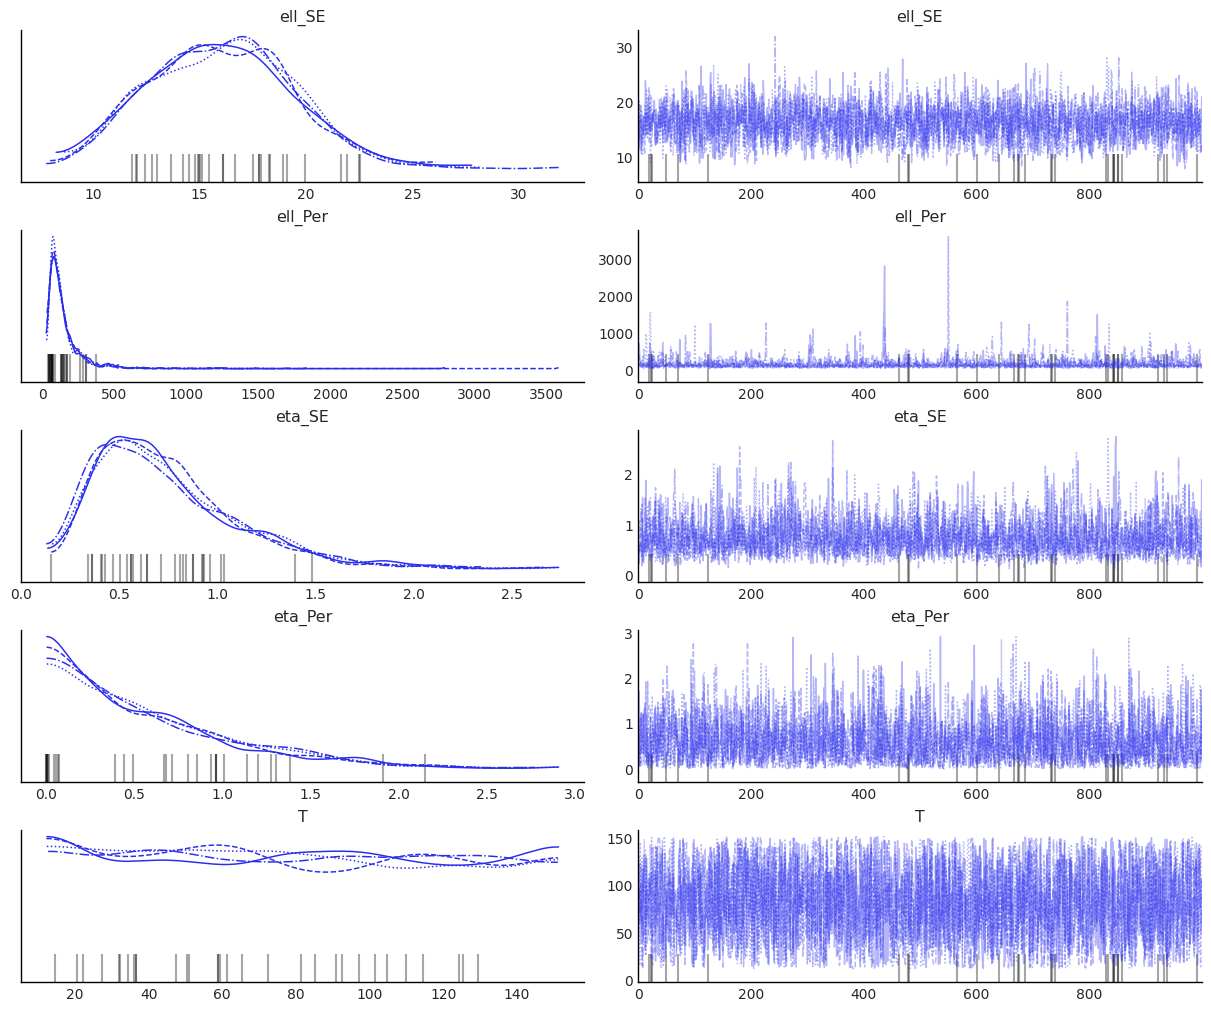

In [7]:
ufn.plot_traces(gpSE_gpPer_trace, variable_names);

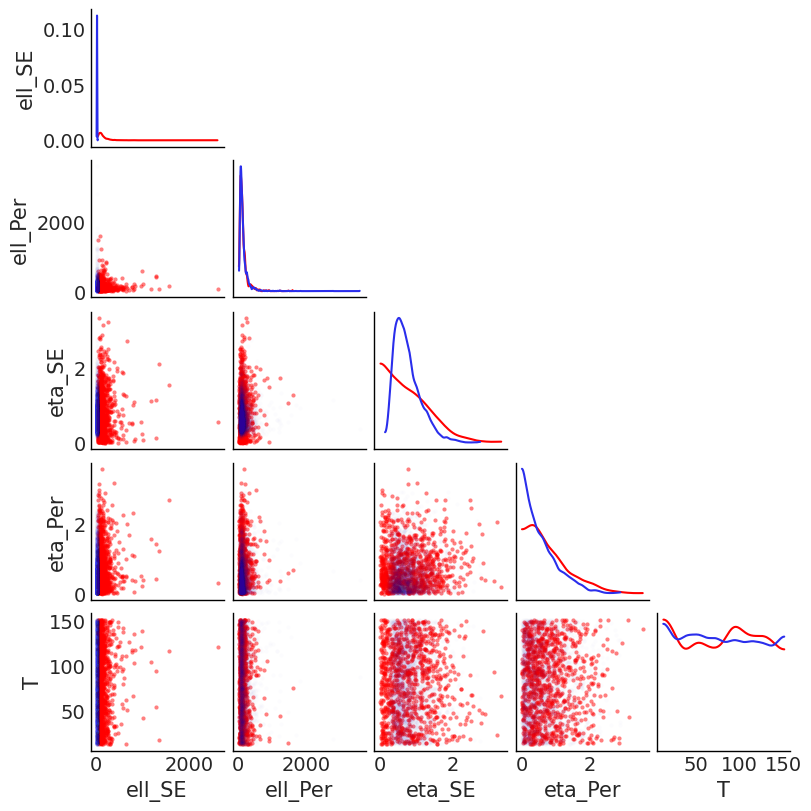

In [8]:
ufn.plot_priorpost_cnr(gpSE_gpPer_trace, variable_names)

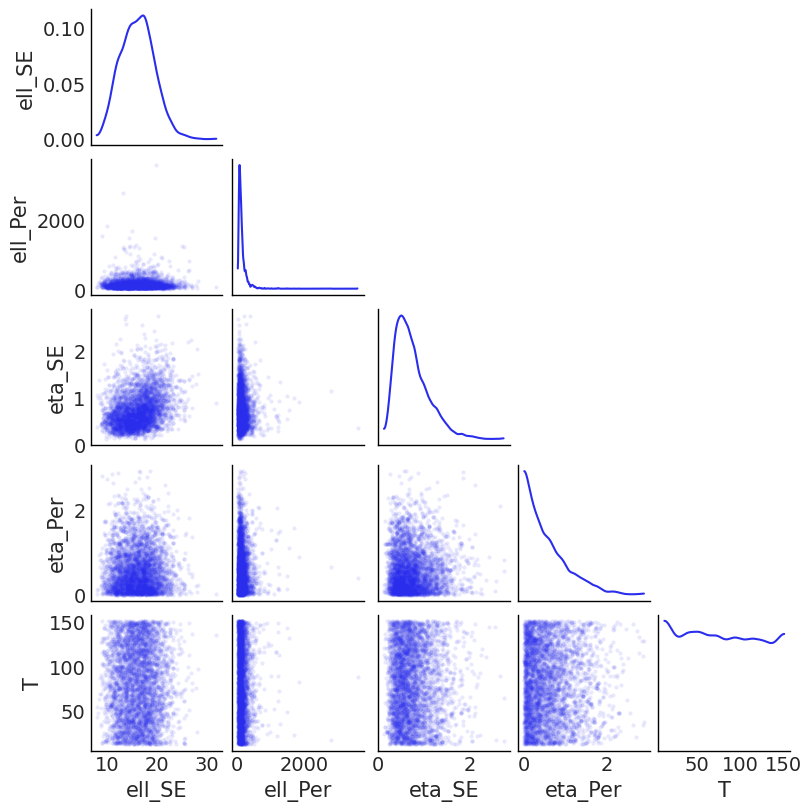

In [9]:
ufn.plot_post_cnr(gpSE_gpPer_trace, variable_names=variable_names)

array([ 36.45568099,  53.87967289,  71.30366478,  19.0316891 ,
        92.21245506, 113.12124533, 123.57564047, 102.66685019])

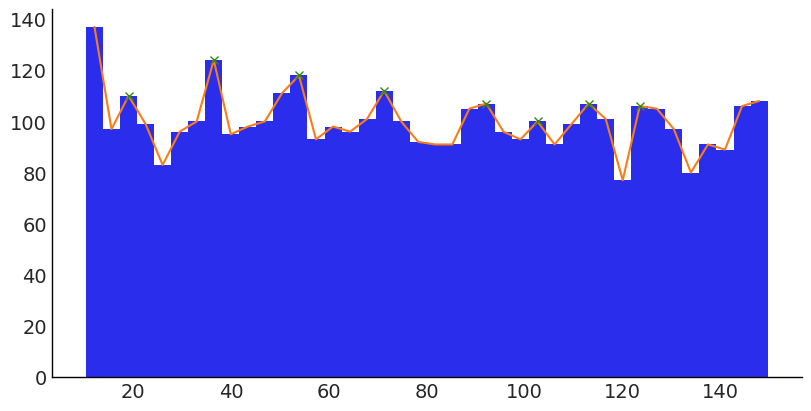

In [10]:
from scipy.signal import find_peaks

fig = plt.figure(figsize=(8,4))
ax = fig.add_subplot(1,1,1)
n, bins, patches = ax.hist(az.extract(gpSE_gpPer_trace, group="posterior", var_names="T"), align="left", bins=40);

peaks, _ = find_peaks(n, height=100)
ax.plot(bins[0:-1],n)
ax.plot(bins[peaks], n[peaks], "x")
T_modes = bins[peaks][np.argsort(-n[peaks])] # peak locations, descending order by height
T_modes

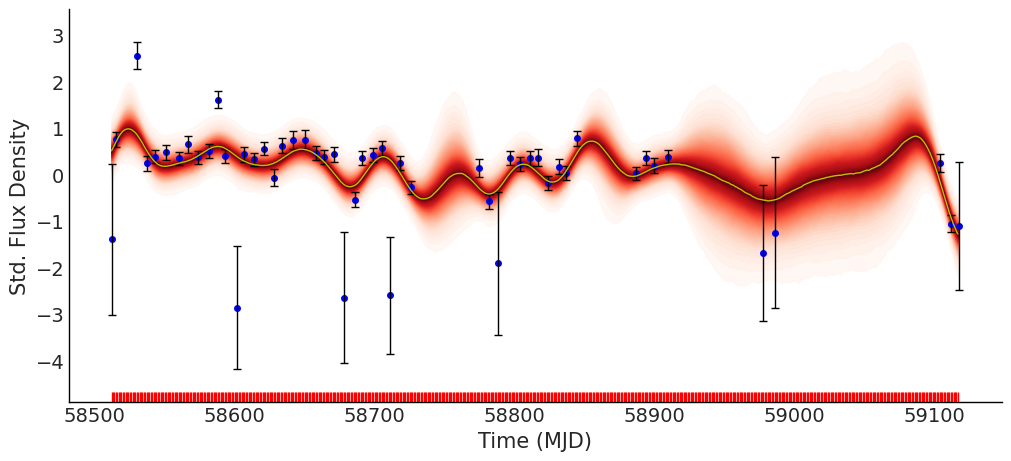

In [25]:
ufn.plot_postpred_samples(gpSE_gpPer_trace, "f_star_SE")
plt.savefig(f"figures/{csv_path.stem}_postpred_fstarSE.jpg", dpi=300, bbox_inches='tight')

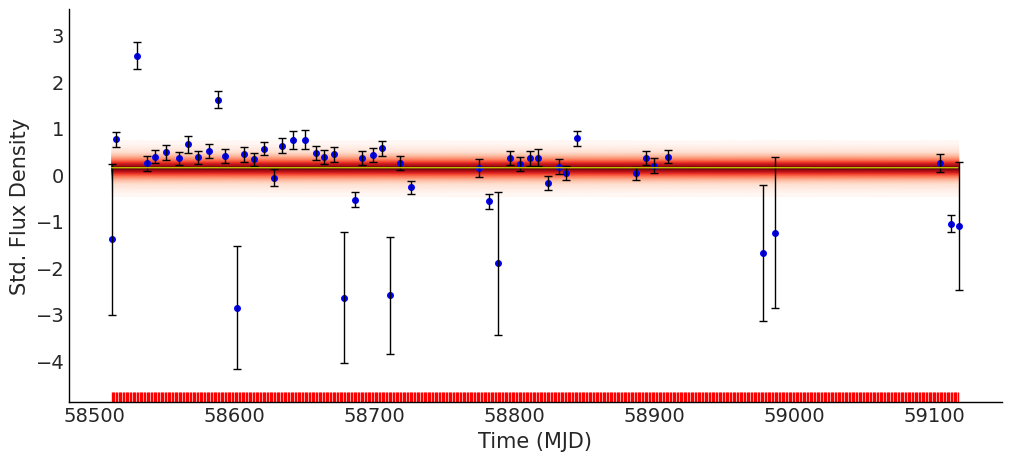

In [26]:
ufn.plot_postpred_samples(gpSE_gpPer_trace, "f_star_Per")
plt.savefig(f"figures/{csv_path.stem}_postpred_fstarPer.jpg", dpi=300, bbox_inches='tight')

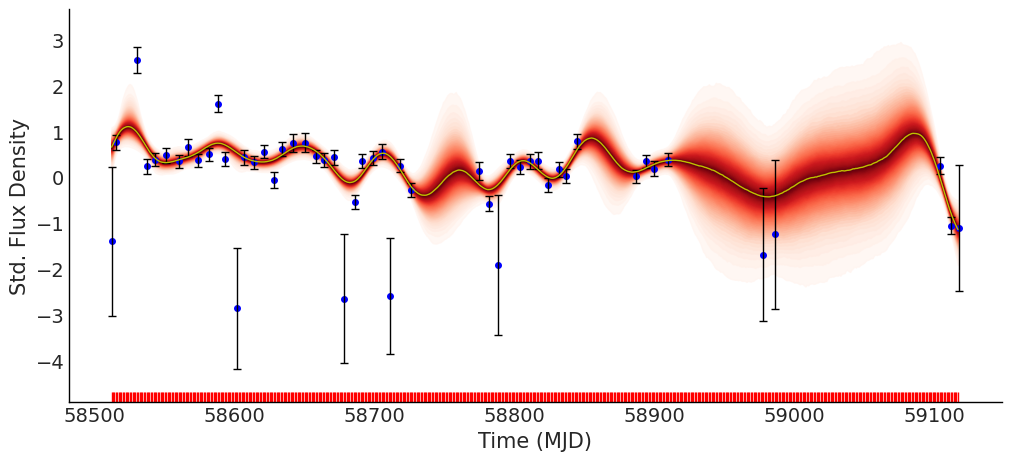

In [27]:
ufn.plot_postpred_samples(gpSE_gpPer_trace, "f_star")
plt.savefig(f"figures/{csv_path.stem}_postpred_fstar.jpg", dpi=300, bbox_inches='tight')

/home/scf/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2017: UserWarning: nperseg = 256 is greater than input length  = 51, using nperseg = 51
  warnings.warn('nperseg = {0:d} is greater than input length '


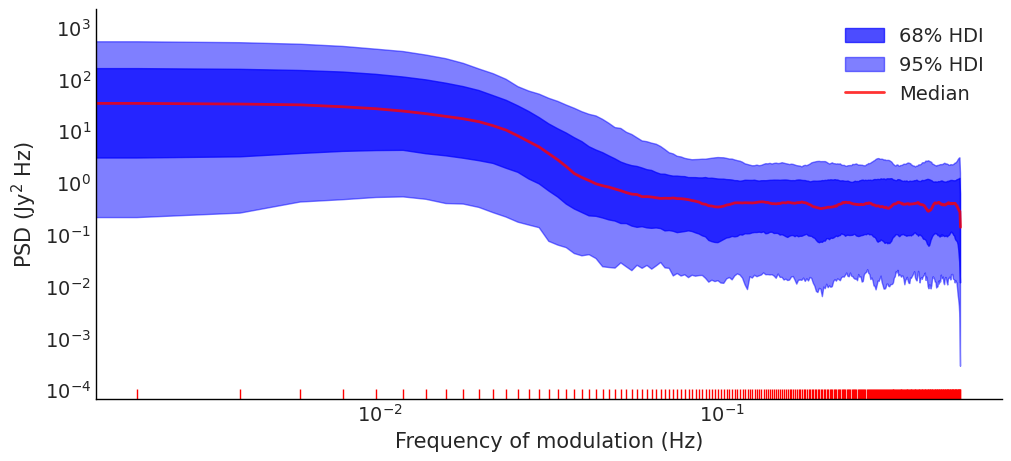

In [14]:
ufn.plot_welch_psd(gpSE_gpPer_trace, group="prior_predictive", variable_name="y")
this_xlim = plt.xlim()
plt.savefig(f"figures/{csv_path.stem}_priorpred_welchpsd.jpg", dpi=300, bbox_inches='tight')

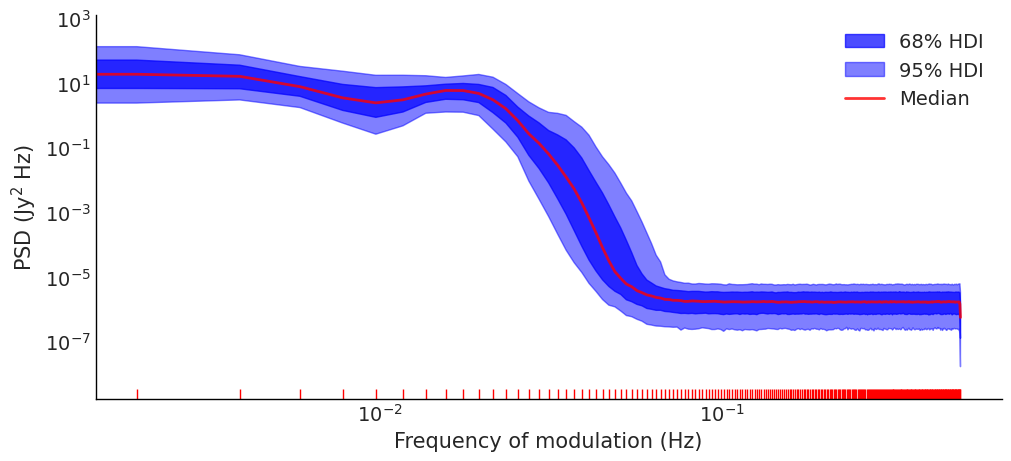

In [15]:
ufn.plot_welch_psd(gpSE_gpPer_trace, group="posterior_predictive", variable_name="f_star_SE");
plt.savefig(f"figures/{csv_path.stem}_postpred_welchpsd_fstarSE.jpg", dpi=300, bbox_inches='tight')

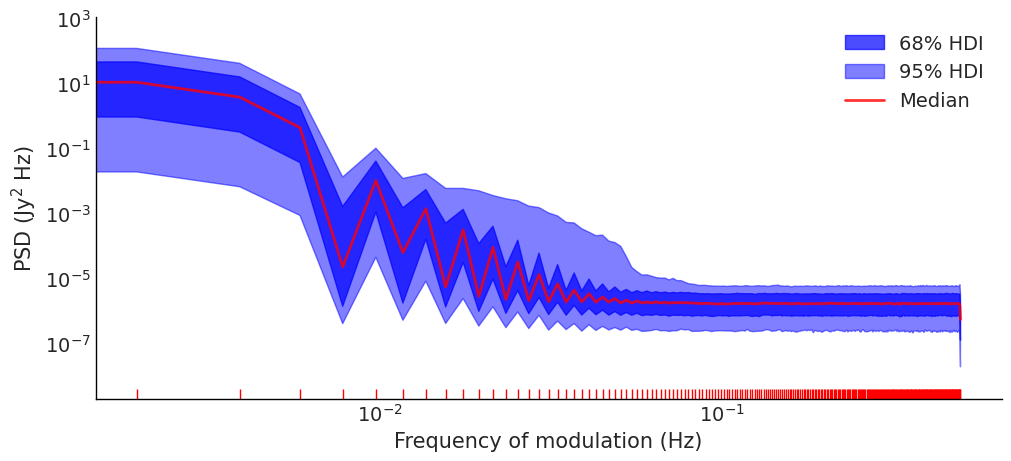

In [16]:
ufn.plot_welch_psd(gpSE_gpPer_trace, variable_name="f_star_Per");
plt.savefig(f"figures/{csv_path.stem}_postpred_welchpsd_fstarPer.jpg", dpi=300, bbox_inches='tight')

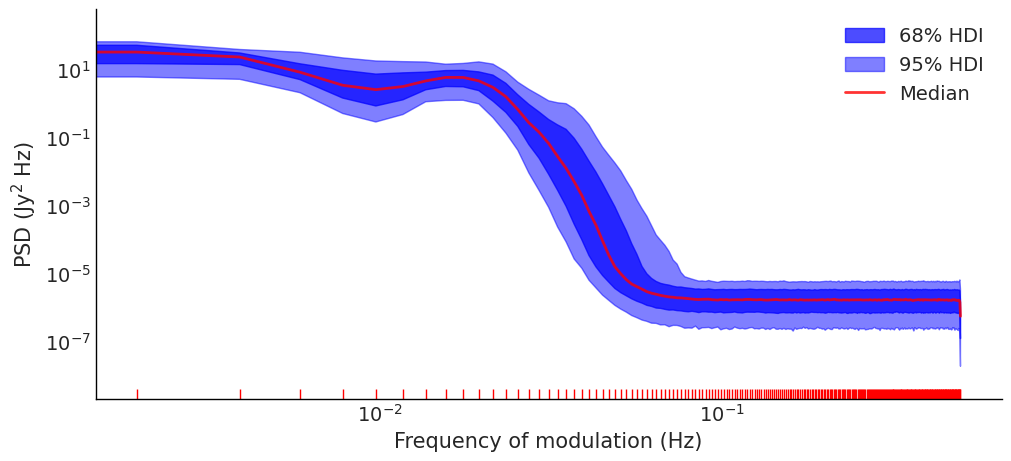

In [17]:
ufn.plot_welch_psd(gpSE_gpPer_trace, group="posterior_predictive", variable_name="f_star")
plt.savefig(f"figures/{csv_path.stem}_postpred_welchpsd_fstar.jpg", dpi=300, bbox_inches='tight')

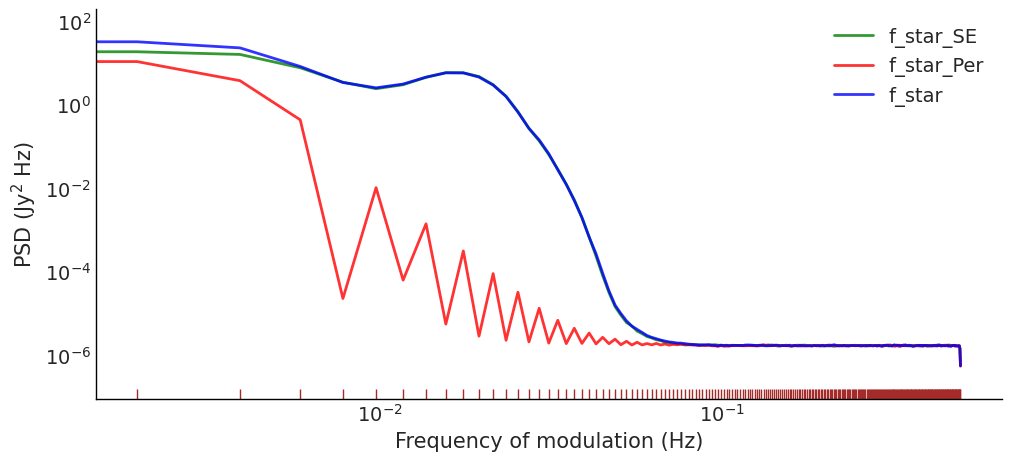

In [18]:
ufn.plot_welch_psds(gpSE_gpPer_trace)
plt.savefig(f"figures/{csv_path.stem}_postpred_welchpsds.jpg", dpi=300, bbox_inches='tight')

/home/scf/.venv/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1563: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a,
/home/scf/.venv/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1563: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a,
/home/scf/.venv/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1563: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a,
/home/scf/.venv/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1563: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a,


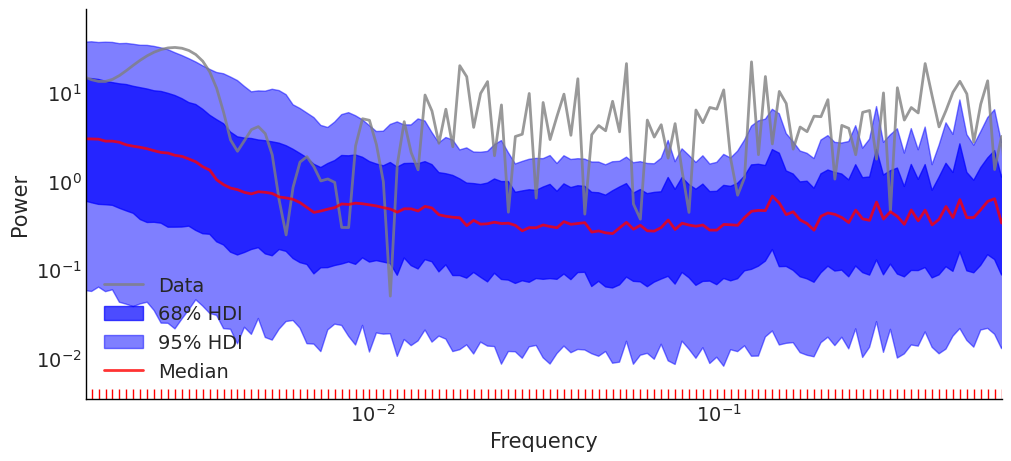

In [29]:
ufn.plot_lsp(gpSE_gpPer_trace, "prior_predictive", "y")
plt.xlim(this_xlim);
plt.savefig(f"figures/{csv_path.stem}_priorpred_lsp.jpg", dpi=300, bbox_inches='tight')

/home/scf/.venv/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1563: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a,
/home/scf/.venv/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1563: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a,
/home/scf/.venv/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1563: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a,
/home/scf/.venv/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1563: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a,


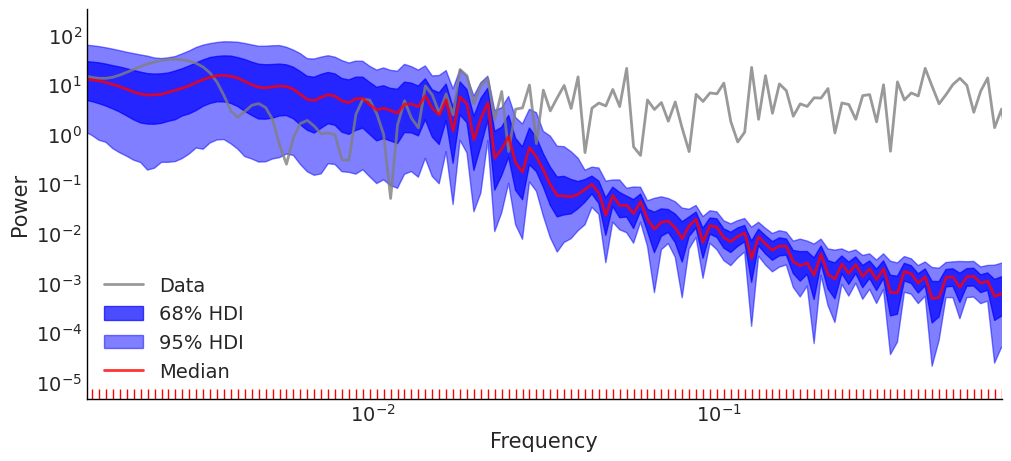

In [30]:
freqs, lsp_median = ufn.plot_lsp(gpSE_gpPer_trace, group="posterior_predictive", variable_name="f_star")
plt.xlim(this_xlim);
plt.savefig(f"figures/{csv_path.stem}_postpred_lsp_fstar.jpg", dpi=300, bbox_inches='tight')

/home/scf/.venv/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1563: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a,
/home/scf/.venv/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1563: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a,
/home/scf/.venv/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1563: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a,
/home/scf/.venv/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1563: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a,


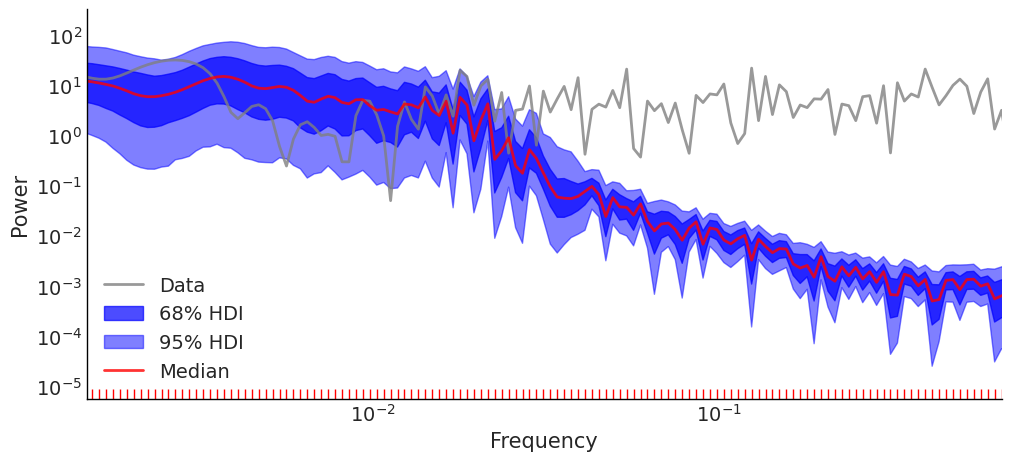

In [31]:
ufn.plot_lsp(gpSE_gpPer_trace, group="posterior_predictive", variable_name="f_star_SE")
plt.xlim(this_xlim);
plt.savefig(f"figures/{csv_path.stem}_postpred_lsp_fstarSE.jpg", dpi=300, bbox_inches='tight')

/home/scf/.venv/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1563: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a,
/home/scf/.venv/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1563: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a,
/home/scf/.venv/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1563: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a,
/home/scf/.venv/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1563: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a,


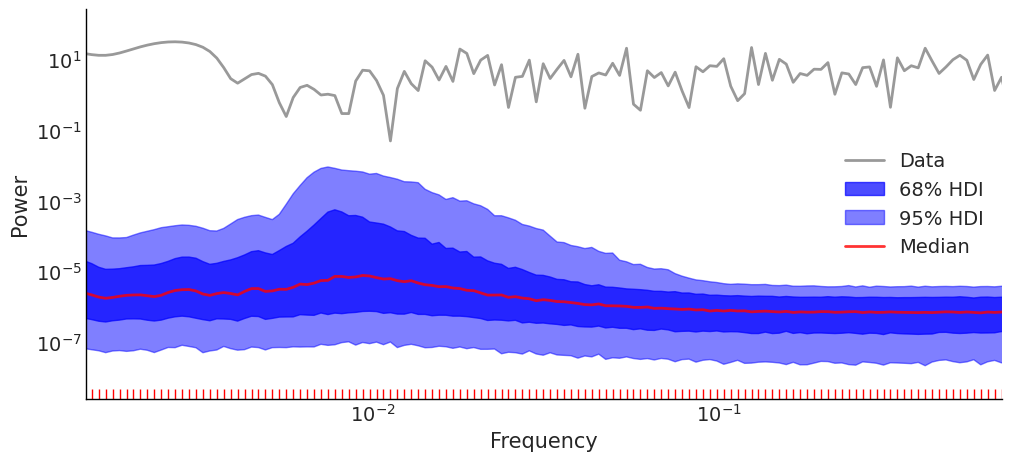

In [32]:
ufn.plot_lsp(gpSE_gpPer_trace, group="posterior_predictive", variable_name="f_star_Per")
plt.xlim(this_xlim);
plt.savefig(f"figures/{csv_path.stem}_postpred_lsp_fstarPer.jpg", dpi=300, bbox_inches='tight')

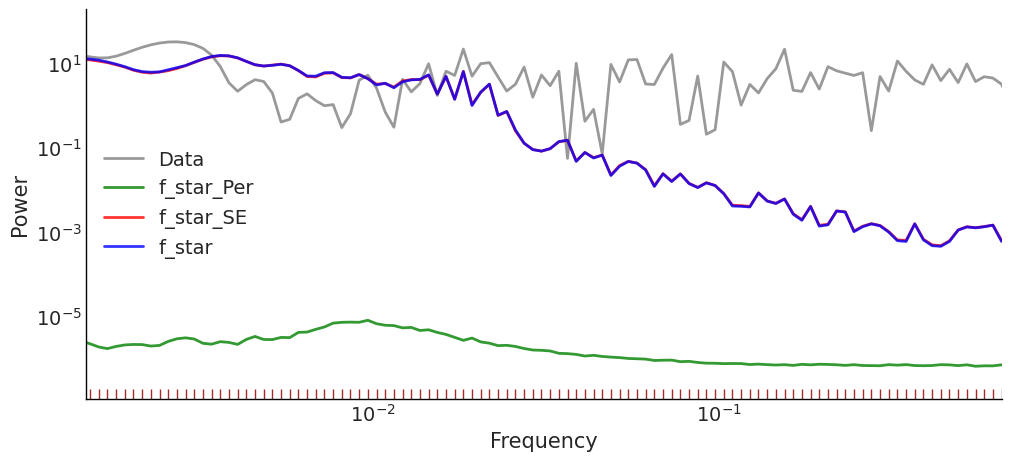

In [36]:
ufn.plot_lsps(gpSE_gpPer_trace, group="posterior_predictive", variable_names=["f_star_Per", "f_star_SE", "f_star"])
plt.xlim(this_xlim);
plt.savefig(f"figures/{csv_path.stem}_postpred_lsps.jpg", dpi=300, bbox_inches='tight')